# Adversarial Validation

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)
sns.set_theme(context="notebook", style="whitegrid")

In [2]:
# check whether scikit-lego and feature-engine are installed
try:
    import sklego, feature_engine
except ImportError:
    import sys

    !{sys.executable} -m pip install scikit-lego feature-engine -q

## Config

In [3]:
# file paths
DATA_DIR = Path("../input/alvin-smart-money-classification-challenge")

# data
TRAIN_DATA = DATA_DIR / "train.csv"

TEST_DATA = DATA_DIR / "test.csv"

EXTRA_DATA = DATA_DIR / "extra_data.csv"

# columns in the data
INDEX_COL = "Transaction_ID"

TARGET_COL = "MERCHANT_CATEGORIZED_AS"

# random state
RANDOM_SEED = 98765

## Loading the data

In [4]:
dt_cols = ["MERCHANT_CATEGORIZED_AT", "PURCHASED_AT"]
train_df = pd.read_csv(
    TRAIN_DATA, index_col=INDEX_COL, parse_dates=dt_cols
)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, ID_04mk78fa to ID_zztijwt3
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   MERCHANT_CATEGORIZED_AT                373 non-null    datetime64[ns, UTC]
 1   MERCHANT_NAME                          373 non-null    object             
 2   MERCHANT_CATEGORIZED_AS                373 non-null    object             
 3   PURCHASE_VALUE                         373 non-null    int64              
 4   PURCHASED_AT                           373 non-null    datetime64[ns, UTC]
 5   IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY  373 non-null    bool               
 6   USER_AGE                               61 non-null     float64            
 7   USER_GENDER                            367 non-null    object             
 8   USER_HOUSEHOLD                         373 non-null    int64              
 9

In [5]:
test_df = pd.read_csv(
    TEST_DATA, index_col=INDEX_COL, parse_dates=dt_cols
)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558 entries, ID_00x9h2yx to ID_zz7zds1s
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   MERCHANT_CATEGORIZED_AT                558 non-null    datetime64[ns, UTC]
 1   MERCHANT_NAME                          558 non-null    object             
 2   PURCHASE_VALUE                         558 non-null    int64              
 3   PURCHASED_AT                           558 non-null    datetime64[ns, UTC]
 4   IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY  558 non-null    bool               
 5   USER_AGE                               85 non-null     float64            
 6   USER_GENDER                            553 non-null    object             
 7   USER_HOUSEHOLD                         558 non-null    int64              
 8   USER_INCOME                            558 non-null    int64              
 9

In [6]:
extra_df = pd.read_csv(
    EXTRA_DATA, index_col=INDEX_COL, parse_dates=dt_cols
)
extra_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, ID_v13grrw3 to ID_cxhvhlnw
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   MERCHANT_CATEGORIZED_AT                0 non-null      datetime64[ns]     
 1   MERCHANT_NAME                          10000 non-null  object             
 2   MERCHANT_CATEGORIZED_AS                0 non-null      float64            
 3   PURCHASE_VALUE                         10000 non-null  int64              
 4   PURCHASED_AT                           10000 non-null  datetime64[ns, UTC]
 5   IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY  10000 non-null  bool               
 6   USER_AGE                               1158 non-null   float64            
 7   USER_GENDER                            9966 non-null   object             
 8   USER_HOUSEHOLD                         10000 non-null  int64              


## Preprocessing

In [7]:
from feature_engine.datetime import DatetimeFeatures
from sklearn.base import clone
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder
from sklego.preprocessing import IdentityTransformer
from xgboost import XGBClassifier

In [8]:
ts_features = ["month", "day_of_month", "day_of_week", "hour"]
ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-999)
gender_pipe = Pipeline([
    ("encode", ordinal_enc),
    ("impute", SimpleImputer(strategy="constant", fill_value=-999))
])

col_trans = make_column_transformer(
    (DatetimeFeatures(features_to_extract=ts_features), ["PURCHASED_AT"]),
    (KBinsDiscretizer(encode="ordinal"), ["PURCHASE_VALUE","USER_INCOME"]),
    (ordinal_enc, ["MERCHANT_NAME", "USER_ID"]),
    (gender_pipe, ["USER_GENDER"]),
    (IdentityTransformer(), ["IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY", "USER_HOUSEHOLD"]),
    n_jobs=-1,
)

pipe = Pipeline([
    ("transformer", col_trans),
    ("model", XGBClassifier(random_state=RANDOM_SEED))
])

In [9]:
from sklearn import set_config

set_config(display="diagram")
pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('datetimefeatures',
                                                  DatetimeFeatures(features_to_extract=['month',
                                                                                        'day_of_month',
                                                                                        'day_of_week',
                                                                                        'hour']),
                                                  ['PURCHASED_AT']),
                                                 ('kbinsdiscretizer',
                                                  KBinsDiscretizer(encode='ordinal'),
                                                  ['PURCHASE_VALUE',
                                                   'USER_INCOME']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=98765, reg_alpha=None,
                               reg_lambda=None, ...))])

In [10]:
# helper function
def get_feature_names(pipe: Pipeline) -> list:
    """Get the feature names of the transformed matrix"""
    col_trans = pipe.named_steps["transformer"]
    transformers = col_trans.named_transformers_
    transformers.pop("remainder")
    feature_names = []
    for idx, transformer in enumerate(transformers.values()):
        try:
            features = transformer.get_feature_names_out()
        except AttributeError:
            features = getattr(
                transformer,
                "feature_names_in_",
                col_trans.transformers[idx][-1]
            )
        # add the elements to the end of the list
        feature_names.extend(features)
    return feature_names

## Train vs test

In [11]:
# utility functions
def create_dataset(train, other, target_col="is_test"):
    try:
        train = train.drop(TARGET_COL, axis=1)
    except KeyError:
        pass

    train[target_col] = 0
    other[target_col] = 1
    df = pd.concat([train, other]).sample(
        frac=1, random_state=RANDOM_SEED
    )
    print(df[target_col].value_counts())
    
    y = df[target_col]
    X = df.drop(target_col, axis=1)
    return X, y

def get_shap_values(pipe, X, y):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, random_state=RANDOM_SEED
    )
    pipe = clone(pipe)
    pipe.fit(X_train, y_train)
    transformer = pipe.named_steps["transformer"]
    X_val_trans = transformer.transform(X_val)

    explainer = shap.TreeExplainer(pipe.named_steps["model"])
    shap_values = explainer.shap_values(X_val_trans)
    return pipe, shap_values, X_val_trans

In [12]:
X, y = create_dataset(train_df, test_df)
cv_results = cross_val_score(pipe, X, y, scoring="roc_auc")
cv_results = pd.DataFrame(cv_results, columns=["AUC"])
cv_results.describe().loc[["mean", "std"]]

1    558
0    373
Name: is_test, dtype: int64


,AUC
mean,0.442959
std,0.019198


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


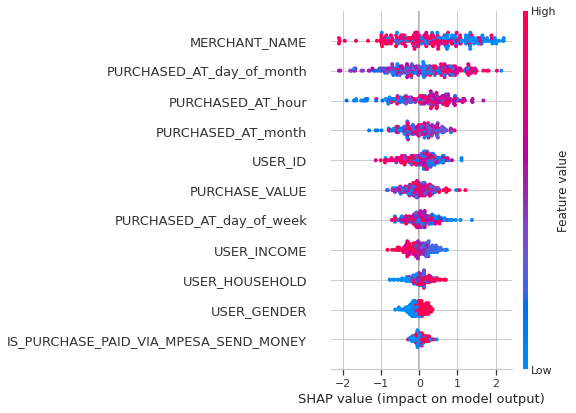

In [13]:
pipe, shap_values, X_val_trans = get_shap_values(pipe, X, y)
shap.summary_plot(
    shap_values,
    features=X_val_trans,
    feature_names=get_feature_names(pipe),
    class_names=pipe.named_steps["model"].classes_,
)

## Train vs extra

In [14]:
X, y = create_dataset(train_df, extra_df, target_col="is_extra")
cv_results = cross_val_score(pipe, X, y, scoring="roc_auc")
cv_results = pd.DataFrame(cv_results, columns=["AUC"])
cv_results.describe().loc[["mean", "std"]]

1    10000
0      373
Name: is_extra, dtype: int64


,AUC
mean,0.931185
std,0.014808


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


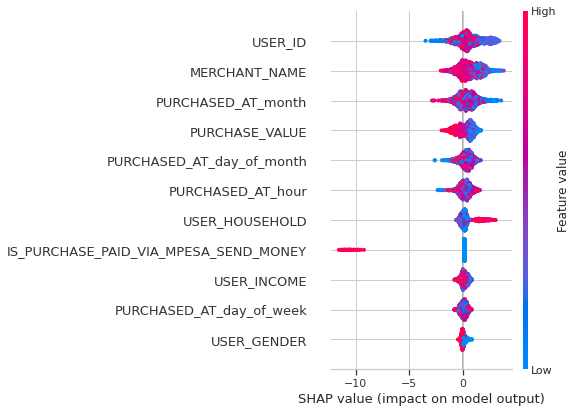

In [15]:
pipe, shap_values, X_val_trans = get_shap_values(pipe, X, y)
shap.summary_plot(
    shap_values,
    features=X_val_trans,
    feature_names=get_feature_names(pipe),
    class_names=pipe.named_steps["model"].classes_,
)